##  read inputs, handle missing values, scale input/output, convert to float32

In [3]:
from faceKeySrc import load_data,linear_regresion, shared_dataset, plot_train_valid
import theano.tensor as T
import theano
import numpy

Using gpu device 0: GeForce GTX 960


In [4]:
FTRAIN = 'data/training.csv'
FTEST = 'data/test.csv'
X, Y = load_data(FTRAIN)

This implementation is based on Lisa-lab's tutorial on theano

### first write a multi-target linear regression

In [5]:
# generate train and validation sets
from sklearn.cross_validation import train_test_split
train_set_x, valid_set_x, train_set_y, valid_set_y = train_test_split(
    X, Y, test_size=0.3, random_state=42
)
train_set_x, train_set_y = shared_dataset(train_set_x, train_set_y)
valid_set_x, valid_set_y = shared_dataset(valid_set_x, valid_set_y)

### sgd optimization

In [41]:
def sgd_linear_reg_multi_target_earlyStop(train_set_x, train_set_y,
                                          valid_set_x, valid_set_y,
                                          learning_rate=0.01,
                                          n_epochs=1000,
                                          batch_size=100,
                                          patience = 500,  # look as this many examples regardless,
                                          improvement_threshold = 0.995,  # a relative improvement of this much is
                                                        # considered significant
                                          patience_increase = 2,  # wait this much longer when a new best is
                                         ):
    
    #compute the number of mini batches
    n_train_batches= train_set_x.get_value(borrow=True).shape[0] // batch_size
    n_valid_batches = valid_set_x.get_value(borrow=True).shape[0] // batch_size
    print('...building the model')
    
    # allocate symbolic variable for data
    index = T.lscalar()
    
    # generate symbolic variable for data - x, y represent a single batch
    x= T.matrix('x')
    y=T.matrix('y')
    
    # construct the regressor
    linear_regressor = linear_regresion(input=x , n_in= 96 * 96, n_out=30)
    
    # compile a theano function to report the validation cost
    validate_model = theano.function(
        inputs=[index],
        outputs=linear_regressor.loss_MSE(y),
        givens={
            x: valid_set_x[index * batch_size: (index + 1) * batch_size],
            y: valid_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )
    
    # the cost we minimise is MSE
    cost = linear_regressor.loss_MSE(y)
    # compute the gradient of cost
    g_W = T.grad(cost=cost, wrt= linear_regressor.W)
    g_b = T.grad(cost=cost, wrt= linear_regressor.b)
    
    # how to update parameters of the model
    updates=[(linear_regressor.W, linear_regressor.W - learning_rate * g_W),
             (linear_regressor.b, linear_regressor.b - learning_rate * g_b)]
    
    # compile a theano function that concurrently returns the cost
    # and updates the model based on the update rules in updates
    train_model = theano.function(
        inputs=[index],
        outputs=cost,
        updates=updates,
        givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size],
            y: train_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )
    
    #train with earky stopping
    history_train_loss, history_validation_loss=train_early_stopping(train_model=train_model,
                                                                     validate_model=validate_model,
                                                                     n_epochs=n_epochs,
                                                                     n_train_batches=n_train_batches,
                                                                     n_valid_batches=n_valid_batches,
                                                                     patience = patience,
                                                                     improvement_threshold = improvement_threshold, 
                                                                     patience_increase = patience_increase
                                                                    )
    return history_train_loss, history_validation_loss



In [42]:
def train_early_stopping(train_model,
                         validate_model,
                         n_epochs,
                         n_train_batches,
                         n_valid_batches,
                         patience = 1000,  # look as this many examples regardless,
                         improvement_threshold = 0.995,  # a relative improvement of this much is
                                                        # considered significant
                         patience_increase = 2  # wait this much longer when a new best is
                        ):
    
    validation_frequency = min(n_train_batches, patience // 10)
                                # go through this many
                                # minibatche before checking the network
                                # on the validation set; in this case we
                                # check every epoch
    
    best_validation_loss = numpy.inf
    test_score = 0.
    # start_time = timeit.default_timer()
    
    done_looping = False
    epoch = 0
    history_validation_loss=numpy.inf#numpy.empty([])
    history_train_loss=numpy.inf#numpy.empty([])
    
    while (epoch < n_epochs) and (not done_looping):
        epoch = epoch + 1
        for minibatch_index in range(n_train_batches):
            minibatch_avg_cost =  train_model(minibatch_index)
            # iteration number
            iter = (epoch - 1) * n_train_batches + minibatch_index
            
            if (iter + 1) % validation_frequency == 0:
                # compute zero-one loss on validation set
                validation_losses = [validate_model(i)
                                     for i in range(n_valid_batches)]
                history_validation_loss = numpy.append(history_validation_loss,numpy.mean(validation_losses))
                
                train_losses = [train_model(i)
                                for i in range(n_train_batches)]
                history_train_loss = numpy.append(history_train_loss,numpy.mean(train_losses))
                #             print(
                #                 'epoch %i, minibatch %i/%i, validation error %f %%' %
                #                 (
                #                     epoch,
                #                     minibatch_index + 1,
                #                     n_train_batches,
                #                     this_validation_loss 
                #                 )
                #             )
                if patience <= iter:
                    #one_looping = True
                    break
    return history_train_loss, history_validation_loss
                    

In [80]:
history_train_loss, history_validation_loss=sgd_linear_reg_multi_target_earlyStop(train_set_x, train_set_y,
                                                                                  valid_set_x, valid_set_y,
                                                                                  learning_rate=0.01,
                                                                                  n_epochs=300,
                                                                                  batch_size=10,
                                                                                  patience = 500, 
                                                                                  improvement_threshold = 0.999,
                                                                                  patience_increase = 2, 
                                                                                 )

...building the model


### plot train valid curves

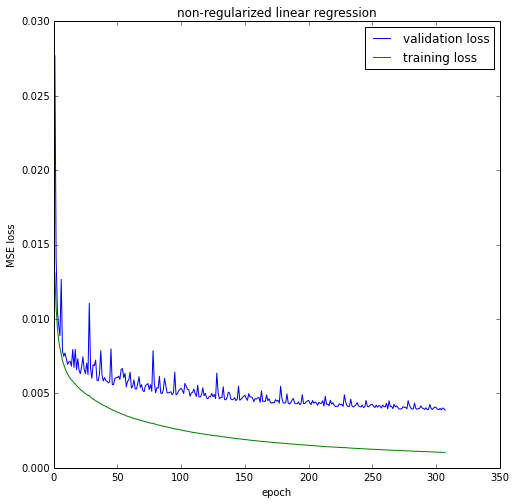

In [81]:
%matplotlib inline
plot_train_valid(history_train_loss=history_train_loss,
                 history_validation_loss=history_validation_loss)

In [75]:
def predict():
    return "not implemented yet"